In [2]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [47]:
import csv

def import_csv_to_dict(file_paths):
    data = {
        "Description": set(),
        "IncidentCategory": set(),
    }

    for file_path in file_paths:
        with open(file_path, 'r') as csv_file:
            reader = csv.DictReader(csv_file)
            
            for row in reader:
                description = row["Description"]
                incident_category = int(row["IncidentCategory"])
                
                # Check if the row is unique before adding it
                if (description, incident_category) not in zip(data["Description"], data["IncidentCategory"]):
                    data["Description"].add(description)
                    data["IncidentCategory"].add(incident_category)

    data["Description"] = list(data["Description"])
    data["IncidentCategory"] = list(data["IncidentCategory"])

    return data

In [48]:
csv_files = [
    "training_data/crime_data.csv",
    "training_data/fire_data.csv",
    "training_data/health_data.csv",
]

data = import_csv_to_dict(csv_files)

In [49]:
len(data["Description"])

169

In [50]:
import string

def remove_punctuation(input_string):
    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    result = input_string.translate(translator)

    return result

In [51]:
df = pd.DataFrame(data)

df["Description"] = df["Description"].apply(remove_punctuation)

df["Description"] = (
    df["Description"].str.lower()
)

# Tokenization
df["Description"] = df["Description"].apply(nltk.word_tokenize)

# Stop Word Removal
stop_words = set(stopwords.words("english"))
df["Description"] = df["Description"].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)

# Stemming
stemmer = PorterStemmer()
df["Description"] = df["Description"].apply(
    lambda tokens: [stemmer.stem(word) for word in tokens]
)

# Join the tokens back into a single string
df["Description"] = df["Description"].apply(' '.join)

ValueError: All arrays must be of the same length

In [26]:
df

,Description,IncidentCategory
0,campu cafe student snatch anoth bag run theft ...,1
1,courtyard come across group student engag phys...,1
2,music room student report theft music instrume...,1
3,campu park lot wit student attempt break car l...,1
4,courtyard come across group student engag phys...,1
...,...,...
14995,startl student seiz near entranc swiftli reach...,2
14996,hallway student report sudden chest pain appea...,2
14997,bustl corridor spot someon collaps gasp breath...,2
14998,quiet librari student clutch head pain urgent ...,2


In [25]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Description"])

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix,
    df["IncidentCategory"],
    test_size=0.5,
    random_state=42,
)

In [35]:
# Train the SVM Model
svm_classifier = SVC(kernel="linear", C=0.5, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(C=0.5, kernel='linear', random_state=42)

In [36]:
# Make predictions on the test set
svm_predictions = svm_classifier.predict(X_test)

# Evaluate the model
report = classification_report(y_test, svm_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2510
           1       1.00      1.00      1.00      2524
           2       1.00      1.00      1.00      2466

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



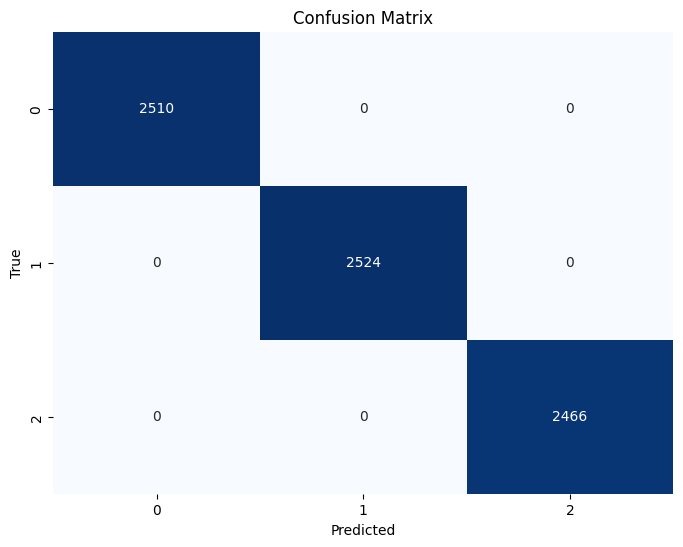

In [37]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, svm_predictions)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
category_names = {0: "Fire", 1: "Crime", 2: "Health"}

# Test user provided response.
user_description = "In the dormitory, a student reports finding graffiti on their door. It appears to be an act of vandalism, and campus security should be notified."

# Preprocess the user's description to match the format used during training
user_description = user_description.lower()  # Convert to lowercase
user_description = user_description.replace(r"[^\w\s]", "")  # Remove punctuation

# Vectorize the user's description using the same TF-IDF vectorizer used during training
user_description_vector = tfidf_vectorizer.transform([user_description])

# Predict the incident category using the trained model
predicted_category = svm_classifier.predict(user_description_vector)

# Map the category label to the actual category name
predicted_category_name = category_names[predicted_category[0]]

# Display the prediction
print(
    "Predicted Incident Category:",
    f"{predicted_category_name} ({predicted_category[0]})",
)

Predicted Incident Category: Health (2)
